In [1]:
import os
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyFAST.input_output as io

# H2@scale specific modules
from generic_electrolyzer import Electrolyzer
from electrolyzer_supervisor import ElectrolyzerSupervisor

from datetime import datetime
plot_date = datetime.today().strftime('%Y%m%d')

debug = True

In [2]:
# Read in Wind Turbine output file from WEIS
turbine_rating_MW = 3.4

#output_dir = os.getcwd() + '/run_weis_for_power_signal/outputs/iea_3p4_halfhour/'
output_dir = os.getcwd() + '/run_weis_for_power_signal/outputs/turbine_input/'
#refturb_file = output_dir + 'refturb_output.csv'
refturb_file = output_dir + 'IEA_10ms.csv'

df = pd.read_csv(refturb_file)
#print(df)
#out_file = output_dir + '/weis_job_0.outb'
out_file = output_dir + 'IEA_10ms.outb'
df = io.fast_output_file.FASTOutputFile(out_file).toDataFrame()

wind_data = np.array(df['GenPwr_[kW]']) # utilizes weis output if weis_driver.py has been run
#print(df)
time_data = np.array(df['Time_[s]'])

# Simple Downsampling to one second
scale = round(1 / 0.01)
new_wind = np.zeros(round(len(wind_data)/scale))
new_time = np.zeros(round(len(time_data)/scale))
for i in range(len(new_wind)):
    new_wind[i] = wind_data[i*scale]
    new_time[i] = time_data[i*scale]

    p_wind = new_wind * 1000
    tspan = new_time

power_input_W = p_wind
if debug: print("Power_input Size:",np.shape(power_input_W))
if debug: print("Timespan Size:", np.shape(tspan))

Power_input Size: (5400,)
Timespan Size: (5400,)


In [3]:
# Initial Conditions and Electrolyzer Parameters
temp_C = 60 # deg C
n_stacks = [1, 2, 3, 5, 8] # np.arange(1,9) # between 1 and 8 stacks

stack_rated_power = 500

electrolyzer_dict = {}
electrolyzer_dict['include_degradation_penalty'] = True
electrolyzer_dict['n_cells']             = 100     # -
electrolyzer_dict['cell_area']           = 1000    # cm**2
electrolyzer_dict['stack_rating_kW']     = stack_rated_power     # kW
electrolyzer_dict['stack_input_voltage'] = 250     # V
electrolyzer_dict['temperature']         = temp_C  # 60degC Case

# --- Current control_type Options ---
    # Rotation-based electrolyzer action schemes:
    # ctrl_type = 'power sharing rotation'     #: power sharing, rotation
    # ctrl_type = 'sequential rotation'        #: sequentially turn on electrolzyers, rotate electrolyzer roles based on set schedule (i.e. variable electrolyzer, etc.)
    # Degredation-based electrolyzer action schemes:
    # ctrl_type = 'even split eager deg'       #: power sharing, eager to turn on electrolyzers
    # ctrl_type = 'even split hesitant deg'    #: power sharing 
    # ctrl_type = 'sequential even wear deg'   #: sequentially turn on electrolzyers, distribute wear evenly
    # ctrl_type = 'sequential single wear deg' #: sequentially turn on electrolyzers, put all degradation on single electrolyzer
    #ctrl_type = 'baseline deg'                #: sequentially turn on and off stacks by their stack numer and don't make an action unless necessary

In [66]:

#ctrl_type = 'baseline deg'   #: sequentially turn on and off stacks by their stack numer and don't make an action unless necessary
ctrl_type = 'power sharing rotation'
#ctrl_types = ['baseline deg', 'power sharing rotation', 'sequential rotation', 'even split eager deg', 'even split hesitant deg', 'sequential even wear deg', 'sequential single wear deg']
ctrl_types = ['baseline deg', 'power sharing rotation', 'even split eager deg', 'sequential even wear deg', 'sequential single wear deg']
#ctrl_type = 'sequential rotation'

#total_curtailed_W = np.zeros([len(ctrl_types), len(n_stacks)])
#ratio_curtailed_W = np.zeros([len(ctrl_types), len(n_stacks)])
total_curtailed_W = np.zeros([len(ctrl_types), len(n_stacks)])
ratio_curtailed_W = np.zeros([len(ctrl_types), len(n_stacks)])

mean_degstate = np.zeros_like(total_curtailed_W)
mean_putil = np.zeros_like(total_curtailed_W)
total_H2_mass_out = np.zeros_like(total_curtailed_W)
# Loop through number of stacks
for c,m in enumerate(ctrl_types):
    print("controller:", ctrl_types[c])
    # Initialize arrays to store data 
    power_left_W = np.zeros([len(power_input_W), len(n_stacks)])
    power_consumed_W = np.zeros_like(power_left_W) 
    power_curtailed_W = np.zeros_like(power_consumed_W)
    power_utilized_factor = np.zeros_like(power_left_W)
    H2_mass_out = np.zeros_like(power_left_W)
    
    for i,n in enumerate(n_stacks):
        print("Number of Stacks:", n)
        H2_mass_flow_rate = np.zeros([len(power_input_W), n])
        electrolyzer_dict['n_stacks'] = n

        e_sup = ElectrolyzerSupervisor(electrolyzer_dict, control_type=ctrl_types[c])
    
        for t in range(len(tspan)):
            H2_mass_out[t,i], H2_mass_flow_rate[t,:], power_left_W[t,i], power_curtailed_W[t,i] = e_sup.control(power_input_W[t])
            #print("Size Pow_Curt:", np.shape(power_curtailed_W))

            power_consumed_W[t,i] = power_input_W[t] - power_left_W[t,i]
            power_utilized_factor[t,i] = min(1., power_consumed_W[t,i] / (stack_rated_power * n * 1e3))
            #if (t%np.round(len(tspan)/10))==0:
            #print(np.round(t/len(tspan)*100), '%')

    
        #if debug: print("H2_flow_rate:", H2_mass_flow_rate)

        total_curtailed_W[c,i] = scipy.integrate.simpson(power_curtailed_W[:,i]) # np.sum(power_curtailed_W[:,i], axis=0)
        total_H2_mass_out[c,i] = scipy.integrate.simpson(H2_mass_out[:,i])
        #print("Total Curtailed Power %d stacks: %2.0f MW" % (n, total_curtailed_W[c,i]/1e6))
        #print("Total H2 Mass out: %3.3f kg" % total_H2_mass_out[c,i])
        #print("Degraded State:", e_sup.deg_state)
        mean_degstate[c,i] = np.sum(e_sup.deg_state)/n
        mean_putil[c,i] = np.mean(power_utilized_factor[:,i])


controller: baseline deg
Number of Stacks: 1
electrolyzer stack  1 out of  1 has been initialized
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power after BLC: [500000.]
Stack Power

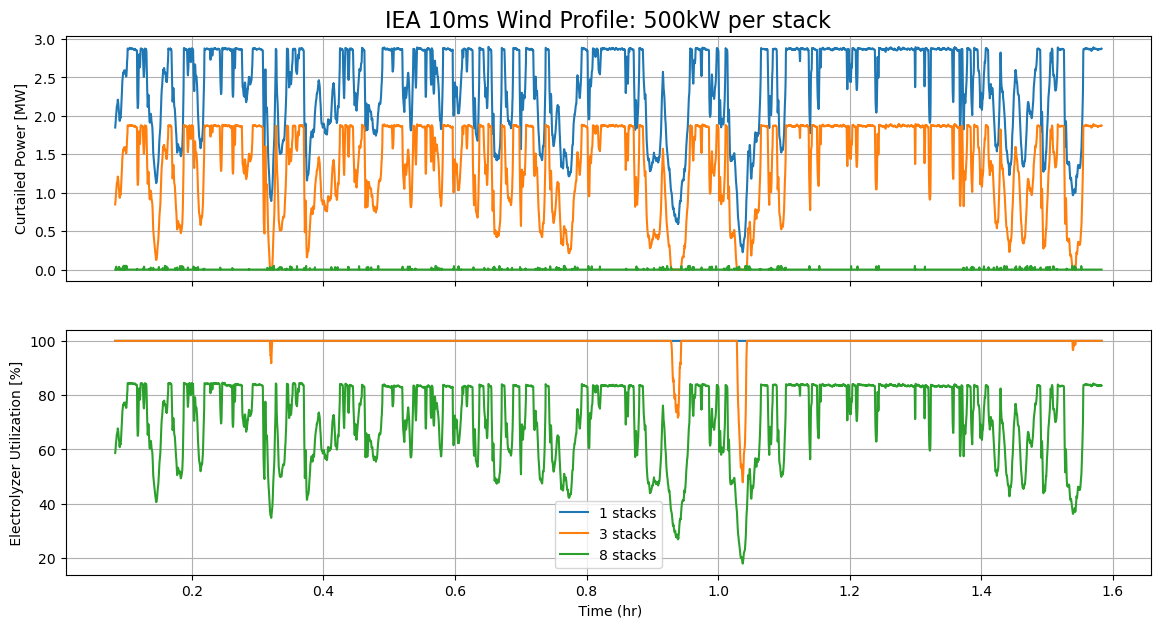

In [45]:
# Plot Time History Results 
tspan_hr = tspan/3600.
power_input_MW = power_input_W/1e6

fig, ax1 = plt.subplots(2,1,figsize=(14, 7),sharex=True)
ax1[0].set_title('IEA 10ms Wind Profile: %dkW per stack' % (stack_rated_power),size=16)

ax1[0].set_ylabel( 'Curtailed Power [MW]')
for x in range(len(n_stacks)):
    if x%2 == 1: continue
    ax1[0].plot(tspan_hr, power_curtailed_W[:,x]/1e6, label='%d stacks' % n_stacks[x])
    ax1[1].plot(tspan_hr, power_utilized_factor[:,x]*100., label='%d stacks' % n_stacks[x])

ax1[1].set_ylabel( ' Electrolyzer Utilization [%] ')
ax1[1].set_xlabel( ' Time (hr)')
ax1[1].legend()
ax1[1].grid()
ax1[0].grid()


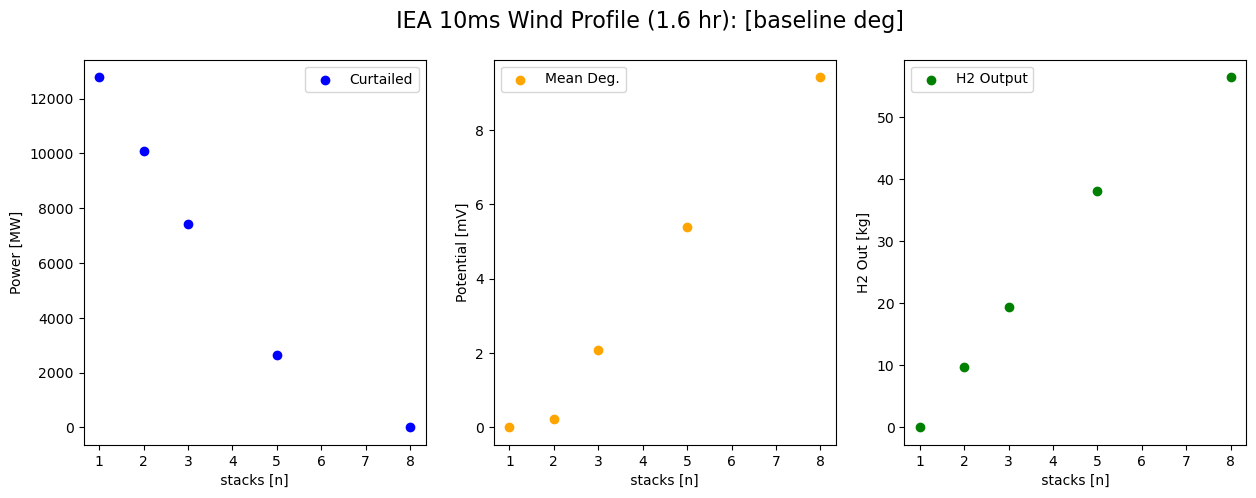

In [46]:
# Plot Total Curtailed Scatter Plot
t_last = time_data[-1]/3600

ind = 0
fig, ax2 = plt.subplots(1,3,figsize=(15, 5))
fig.suptitle( ' IEA 10ms Wind Profile (%1.1f hr): [%s]' % (t_last,ctrl_types[ind]), size=16 )
ax2[0].scatter(n_stacks, total_curtailed_W[ind,:]/1e6, label='Curtailed',color='blue')
ax2[0].set_ylabel( 'Power [MW]')
ax2[0].set_xlabel( ' stacks [n] ')
ax2[0].legend()

ax2[1].scatter(n_stacks, mean_degstate[ind,:]*1e3, label='Mean Deg.',color='orange')

ax2[1].set_ylabel( 'Potential [mV]')
ax2[1].set_xlabel( ' stacks [n] ')
ax2[1].legend()

ax2[2].scatter(n_stacks, total_H2_mass_out[ind,:], label='H2 Output',color='green')

ax2[2].set_ylabel( 'H2 Out [kg]')
ax2[2].set_xlabel( ' stacks [n] ')
ax2[2].legend()


Text(0.5, 0, ' stacks [n] ')

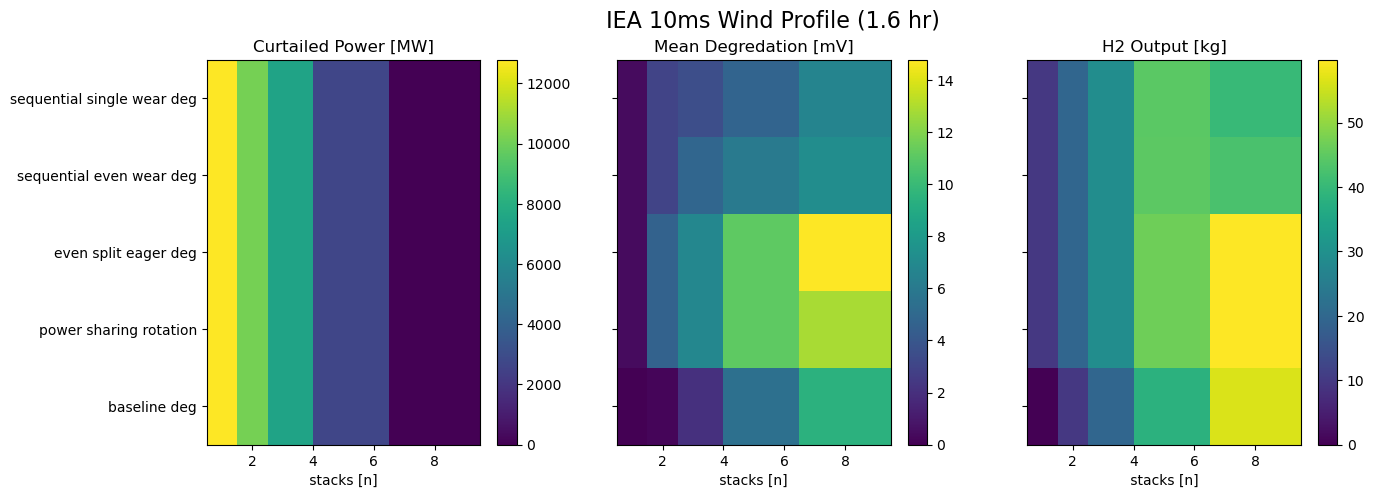

In [65]:
# plot 2D contour heat map 
# controllers on the y-axis 
# n-stacks on the x-axis

fig, ax3 = plt.subplots(1,3,figsize=(15, 5), sharey=True)
fig.suptitle( ' IEA 10ms Wind Profile (%1.1f hr)' % (t_last), size=16 )
ax3[0].set_title("Curtailed Power [MW]")
a1 = ax3[0].pcolormesh(n_stacks, ctrl_types, total_curtailed_W/1e6);
plt.colorbar(a1, ax=ax3[0])
#ax3[0].set_yticks(list(ctrl_types))
ax3[0].set_xlabel( ' stacks [n] ')

ax3[1].set_title("Mean Degredation [mV]")
a2 = ax3[1].pcolormesh(n_stacks, ctrl_types, mean_degstate*1e3);
plt.colorbar(a2, ax=ax3[1])
#ax3[1].set_ylabel( 'Controllers')
ax3[1].set_xlabel( ' stacks [n] ')

ax3[2].set_title("H2 Output [kg]")
a3 = ax3[2].pcolormesh(n_stacks, ctrl_types, total_H2_mass_out);
plt.colorbar(a3, ax=ax3[2])
#ax3[2].set_ylabel( 'Controllers')
ax3[2].set_xlabel( ' stacks [n] ')